<a href="https://colab.research.google.com/github/simami-ml/cds/blob/main/4_4_3_big_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**В этом уроке предлагаем вам упорядочить и систематизировать полученный опыт из предыдущих разделов и оформить ноутбук, который будут проверять такие же студенты как вы.**

Задача с рецензированием, чтобы получить итоговый балл необходимо чтобы вашу работу проверили 3 человека (для объективной оценки), поэтому не поленитесь проверить несколько работ ваших коллег. Если рецензентов будет не хватать, то будет проверка от преподавателей курса. При проверке других работ желательно оставлять поясняющие комментарии, особенно, при снижении баллов (помни заповедь: проверяй других так, как хочешь, чтобы проверяли тебя!).

Постарайтесь подойти к заданию творчески и основательно - возможно, это будет ваш начальный шаблон для дальнейших соревнований, но расписывать огромные простыни на сотню ячеек тоже не стоит.

## Задача
**"Обучи несколько бустингов на 3-х фолдах, выбери лучшие, усредни предсказания"**
Если вы думает, что это задание - больная фантазия авторов, то нет - это, как раз, реальные кейсы с соревнований. Можно назвать это задание подготовкой к модулю про блендинг и стэккинг.

Датасеты: `quickstart_train.csv` и `quickstart_test.csv`

Регрессионный таргет: столбец `target_reg` , метрика `RMSE`

**Модели**, которые необходимо обучить:

- CatBoostRegressor
- LightGBMRegressor (goss)
- XGBoostRegressor (dart)

**Бонусом**, для тех кому покажется мало, можно обучить ещё 3 модели (не влияет на итоговый балл):

- CatBoostRegressor с другим random_seed
- LightGBMRegressor (dart)
- XGBoostRegressor (gbtree)

В этом случае усредняем лучшие фолды от 6 моделей.

**Дополнительные условия**:

- Все модели обучаем на 3-х фолдах
- Выбираем лучший фолд от каждой модели (получаем 6 лучших моделей)
- Обязательно должна быть добавлена ячейка с сохранением 6 лучших моделей
- Делаем итоговое предсказание на тестовом датасете, усреднив предсказание от 6 лучших моделей
- Сохраняем в `submission.csv` только колонки `car_id` и `target_reg`
- В конце добавляем небольшой текстовый блок с выводами
- Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.
- Не добавляем новые признаки
- Не используем GPU
- Не используем Optuna

Что можно использовать (но не обязательно)?
- Feature Selection
- Object importance
- Подбор гиперпараметров
- Графику
- Колбэки, шедулеры, кастомы

Формат сдачи:

- В текстовом поле вводим ссылки на онлайн версию jupyter ноутбука (GoogleСolab, Kaggle) с выполненным заданием, и публичную ссылку на файлхостинг (GoogleDrive, ЯндексДиск или др.) с оригиналом ноутбука. (проверяем, что они работают).
- Во вложение добавляем тот же ноутбук, сохраненный в формате pdf с аутпутами всех ячеек (не более 5 Mb).
- В следующем шаге отправляем получившийся CSV файл с предсказаниями. Можно использовать его, как аналог лидерборда, чтобы узнавать скор предсказаний.


**Критерии оценки (максимум 10 баллов за задание):**

**Оформление (3 балла)**
- прослеживается логика в последовательности решения задачи; в неочевидных местах добалены поясняющие комментарии и маркдаун ячейки. ноутбук не пергружен лишней информацией, огромными простынями аутпутов ячеек (настраиваем verbose, скрываем служебную информацию после установки библиотек)
- хороший codestyle: код соответствует PEP 8 и DRY, названия переменных и функций понятны, либо соответствуют общепринятым нормам (train, test, model, pd, xgb и.т.п.)
- в конце присутствуют выводы о проделанной работе<br>

**Решение задачи и выполнение доп. условий (3 балла)**<br>
- ноутбук выполняется до конца без ошибок (присутствуют все аутпуты в пдф)
- обучены все необходимые модели и выполнены доп. условия
- проведена работа над воспроизводимостью (зафиксированы все random seeds)
- присутствуют и отрабатывают ячейки для сохранения лучших моделей и итогового файла с предсказанием<br>

 **Использование возможностей фрэймворка (2 балла)**<br>
- датсеты загружаются с помощью соответствующих классов (Pool, Dmatrix, Dataset)
- используется early_stopping, многопоточность (n_threads) и пр.
- правильная подготовка категориальных признаков для каждой модели.<br>

 **Дополнительные баллы (макс. 2 балла)**<br>
- 1 балл, если проводился подбор гиперпараметров;
- 1 балл, если использованы минимум 2 вида графики и на основе её сделаны какие-либо выводы (не просто график ради картинки красивой, а с пользой для дела);
- 1 балл, если проводился feature selection или object selection
- 1 балл, если использовались scheduler или custom callbacks

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap

import time
from math import sqrt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,  make_scorer
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
from lightgbm import Dataset

import shap
shap.initjs()

matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings(action="ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore")

start_time = time.time()

In [ ]:
def plot_info_on_numerical_column( _df1, _df2,
                                   _feature_title,
                                   _label = False,
                                   _text_info = True,
                                   _bins = 50,
                                   _figure_width = 17,
                                   _figure_height = 7,
                                   _fontsize=15,
                                   _number_of_decimals = 2,
                                   _title = ''):

    NCOLS_NUMBER_CONST = 1

    if _label == False:
        _label = _feature_title

    fig, ax = plt.subplots(ncols=1, figsize=(_figure_width, _figure_height))

    sns.histplot(data=_df1,
                 x=_feature_title,
                 color="cornflowerblue",
                 label=_label,
                 bins=_bins,
                 kde=True,)
    mean_value = _df1[_feature_title].mean()
    median_value = _df1[_feature_title].median()
    ax.axvline(x=mean_value, color='black', lw = 2, ls = ':',
                  label = "mean: {}".format(round(mean_value, _number_of_decimals)))
    ax.axvline(x=median_value, color='blue', lw = 2, ls = '-.',
                  label = "median: {}".format(round(median_value, _number_of_decimals)))
    ax.legend(fontsize = '15', title_fontsize = "10", loc='upper right')
    plt.tight_layout()

    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    Q1 = _df1[_feature_title].quantile(Q1_QUANTILE_VALUE_CONST)
    Q3 = _df1[_feature_title].quantile(Q3_QUANTILE_VALUE_CONST)
    IQR = Q3 - Q1

 #_________________________________
    sns.histplot(data=_df2,
                 x=_feature_title,
                 color="aquamarine",
                 label=_label,
                 bins=_bins,
                 kde=True)
    mean_value = _df2[_feature_title].mean()
    median_value = _df2[_feature_title].median()
    ax.axvline(x=mean_value, color='green', lw = 2, ls = ':',
                  label = "mean: {}".format(round(mean_value, _number_of_decimals)))
    ax.axvline(x=median_value, color='red', lw = 2, ls = '-.',
                  label = "median: {}".format(round(median_value, _number_of_decimals)))
    ax.legend(fontsize = '15', title_fontsize = "10", loc='upper right')
    plt.tight_layout()

    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    Q1 = _df2[_feature_title].quantile(Q1_QUANTILE_VALUE_CONST)
    Q3 = _df2[_feature_title].quantile(Q3_QUANTILE_VALUE_CONST)
    IQR = Q3 - Q1

    plt.show()


def plot_df_features_info(_df1, _df2,_name):
    print('')
    print(_name)
    print('')
    for _c in _df1.describe().columns:
        plot_info_on_numerical_column(_df1, _df2, _c, _figure_width = 10, _figure_height = 5)

In [ ]:
def ml_rmse(target, pred):
    return np.sqrt(mean_squared_error(target, pred))

rmse_score = make_scorer(ml_rmse, greater_is_better=False)

In [ ]:
def gridsearch(X_, y_, model_, param_grid_, rmse_score):

    for train_index, test_index in kf.split(X_, y_):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        start = time.time()
        print('\n Поиск лучших параметров...')

        gs = GridSearchCV(model_,
                          param_grid_,
                          scoring=rmse_score,
                          n_jobs=-1)

        gs_result = gs.fit(X_train, y_train)

        _time = time.time() - start
        print(f'Время подбора {round((_time)/60, 2)} минут')
        print('Лучшие параметры:   ', gs_result.best_params_)
        print('Лучшая оценка rmse: ', round(np.abs(gs_result.best_score_), 2))

Загрузим файлы, посмотрим на данные

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv")
display(train.head())
train.info()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float64
 5   year_to_start             2337 non-null   int64  
 6   riders                    2337 non-null   int64  
 7   year_to_work              2337 non-null   int64  
 8   target_reg                2337 non-null   float64
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float64
 11  distance_sum              2337 non-null   float64
 12  rating_min                2337 non-null   float64
 13  speed_max                 2337 non-null   float64
 14  user_rid

In [ ]:
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv")
display(test.head())
test.info()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,gear_stick,3.746207,1.407539e+07,0.10,195.454152,10.566220,174,170
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016,engine_overheat,4.318966,1.970390e+07,0.00,181.538685,11.807941,174,174
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,electro_bug,5.134655,9.314946e+06,0.10,118.440645,14.862538,174,172
3,F12725233R,Smart ForFour,economy,petrol,2.80,2014,68833,2021,engine_check,4.617356,9.336838e+06,0.83,112.829785,20.088904,174,172
4,l-1139189J,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,another_bug,4.287471,1.196250e+07,0.00,187.846088,3.698460,174,172


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    1913 non-null   object 
 1   model                     1913 non-null   object 
 2   car_type                  1913 non-null   object 
 3   fuel_type                 1913 non-null   object 
 4   car_rating                1913 non-null   float64
 5   year_to_start             1913 non-null   int64  
 6   riders                    1913 non-null   int64  
 7   year_to_work              1913 non-null   int64  
 8   target_class              1913 non-null   object 
 9   mean_rating               1913 non-null   float64
 10  distance_sum              1913 non-null   float64
 11  rating_min                1913 non-null   float64
 12  speed_max                 1913 non-null   float64
 13  user_ride_quality_median  1913 non-null   float64
 14  deviatio

In [ ]:
cat_features = ["car_type", "fuel_type", "model"]
drop_cols = ["car_id", "target_reg", "target_class"]

X = train.drop(drop_cols, axis=1, errors="ignore")
y = train["target_reg"]

for col in cat_features:
    X[col] = X[col].astype('category')

In [ ]:
random_state = 830425
random_state_2 = 12345
n_splits = 3

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [ ]:
X_train_fold, X_test_fold, y_train_fold, y_test_fold = [],[],[],[]

for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_fold.append(X_train), X_test_fold.append(X_test), y_train_fold.append(y_train), y_test_fold.append(y_test)

Регрессионный таргет: столбец `target_reg` , метрика `RMSE`.

Посмотрим на обучающую и тестовую выборки на графике.


train VS test



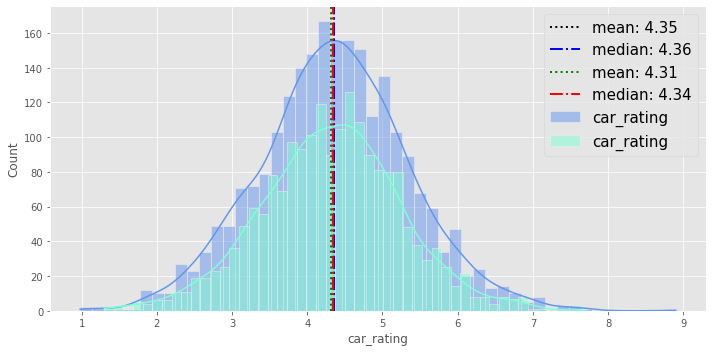

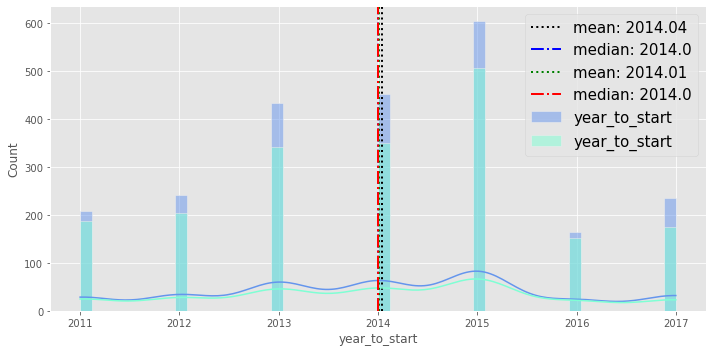

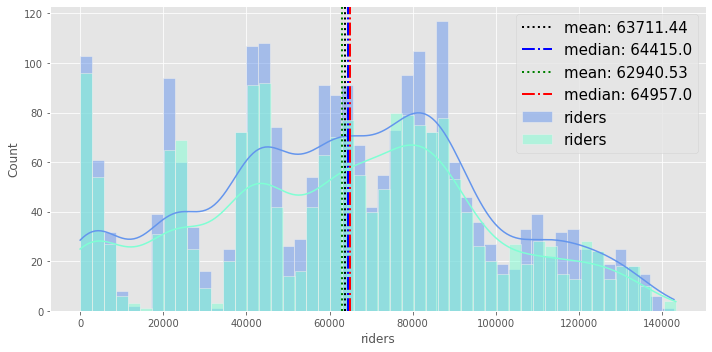

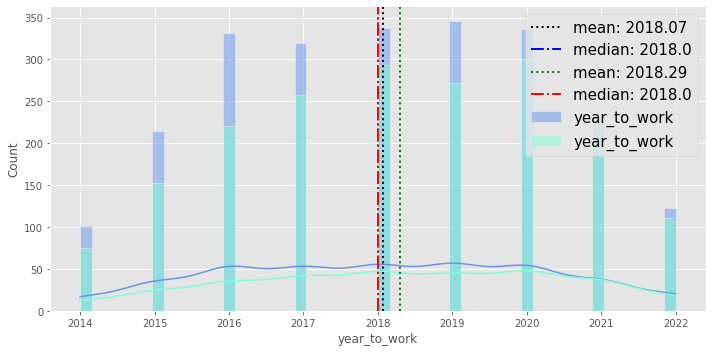

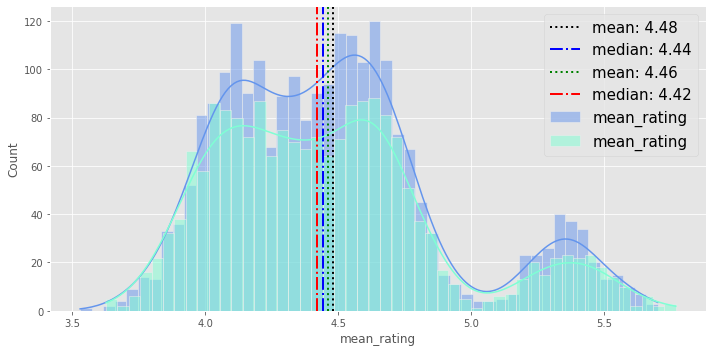

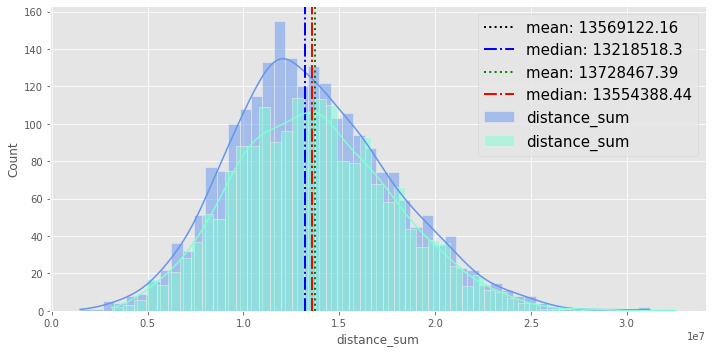

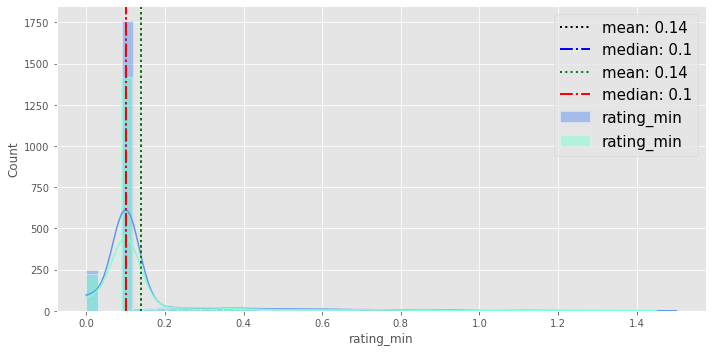

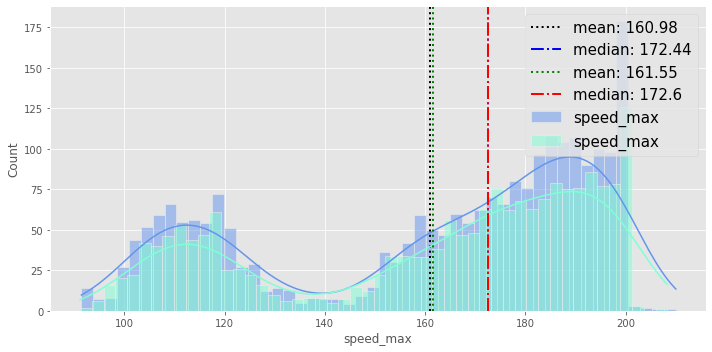

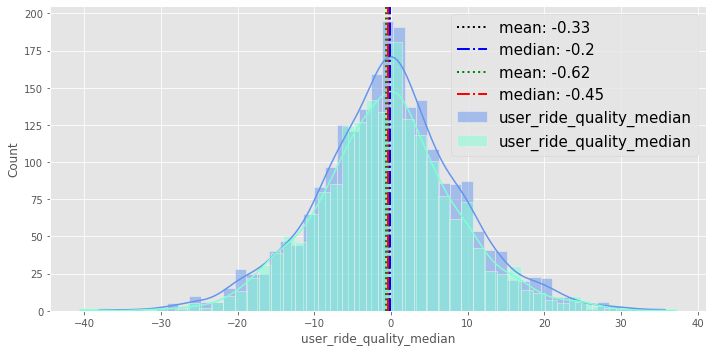

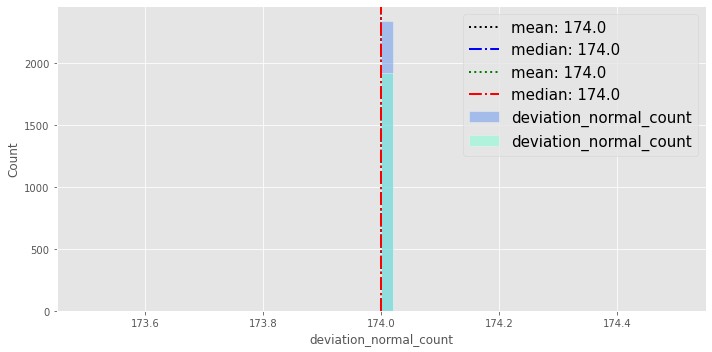

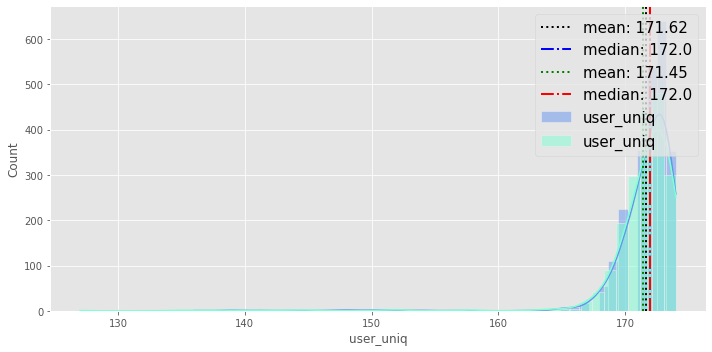

In [ ]:
plot_df_features_info(X, test, 'train VS test')

В целом выборки очень похожи: распредления признаков почти одинаковые. <br>

Далее
- создадим модели **CatBoostRegressor**, **LGBMRegressor**, **XGBRegressor**
- подберем гиперпараметры
- обучим их на 3 фолдах
- посмотрим на важность обучающих признаков, попробуем исключить неважные - возможно это поднимет точность
- сделаем прогноз на основе 6 лучших моделей и усредним результат

## CatBoostRegressor

 ### randomized_search

In [ ]:
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)

    model = CatBoostRegressor(random_state=random_state,
                              cat_features=cat_features,
                              loss_function='RMSE',
                              eval_metric="RMSE",
                              verbose=False,
                              thread_count=-1,
                              early_stopping_rounds=50
                              )

    param_grid =  {'depth': [2, 4, 6],
                   'learning_rate': [0.25, 0.05, 0.01],
                   'l2_leaf_reg': [0, 1, 2, 5],
                   'bootstrap_type': ['No','Bayesian','Bernoulli','Poisson']
                   }

    start = time.time()
    print('\n Поиск лучших параметров для CatBoostRegressor...')

    rs_result = model.randomized_search(param_grid,
                                        X=train_dataset,
                                        y=None,
                                        partition_random_seed=random_state,
                                        shuffle=False,
                                        verbose=False,
                                        plot=False)

    _time = time.time() - start
    print(f'Время подбора {round((_time)/60, 2)} минут')
    print('Лучшие параметры:   ', rs_result['params'])
    print('Лучшая оценка rmse: ', model.best_score_)


 Поиск лучших параметров для CatBoostRegressor...
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.97324222
bestIteration = 65

Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.84064977
bestIteration = 435

Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.00661666
bestIteration = 35

Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.8126435
bestIteration = 38

Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.62005793
bestIteration = 887

Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.6922385
bestIteration = 220

Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.59111308
bestIteration = 198


bestTest = 10.71524101
bestIteration = 997

Training on fold [0/3]

bestTest = 12.65812353
bestIteration = 307

Training on fold [1/3]

bestTest = 11.45649389
bestIteration = 276

Training on fold [2/3]

bestTest = 11.13948393
bestIteration = 327

Время подбор

### CatBoostRegressor random_state

In [ ]:
clfs_rs1 = []
scores_clfs_rs1 = []
idxs_clfs_rs1 = []
idxs_scores_clfs_rs1 = []

for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostRegressor(depth=6,
                            iterations=3000,
                            learning_rate=0.05,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            cat_features=cat_features,
                            l2_leaf_reg=5,
                            bootstrap_type='No',
                            thread_count=-1,
                            random_seed=random_state,
                            early_stopping_rounds=50)

    clfs_rs1.append(clf)

    clf.fit(train_dataset,
            eval_set=eval_dataset,
            verbose=1000,
            use_best_model=True,
            plot=False)

    scores_clfs_rs1.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "RMSE" in k], dtype="float16"))

    idxs, scores = clf.get_object_importance(eval_dataset, train_dataset,
                                             importance_values_sign="Positive", thread_count=-1)
    idxs_clfs_rs1.append(idxs), idxs_scores_clfs_rs1.append(scores)

min_rmse_cb_rs = min(scores_clfs_rs1)
min_index_cb_rs = scores_clfs_rs1.index(min_rmse_cb_rs)

assert len(clfs_rs1) == n_splits
for i in range(len(scores_clfs_rs1)):
    print(f" Model clfs_rs1 {i} RMSE score ---------> {scores_clfs_rs1[i]:.5f}")

0:	learn: 17.3977957	test: 16.7981471	best: 16.7981471 (0)	total: 24.1ms	remaining: 1m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.40358668
bestIteration = 215

Shrink model to first 216 iterations.
0:	learn: 16.9115589	test: 18.1193639	best: 18.1193639 (0)	total: 19ms	remaining: 56.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.02581946
bestIteration = 218

Shrink model to first 219 iterations.
0:	learn: 17.4803822	test: 16.9221843	best: 16.9221843 (0)	total: 30.2ms	remaining: 1m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.21426354
bestIteration = 190

Shrink model to first 191 iterations.
 Model clfs_rs1 0 RMSE score ---------> 11.40625
 Model clfs_rs1 1 RMSE score ---------> 12.02344
 Model clfs_rs1 2 RMSE score ---------> 11.21094


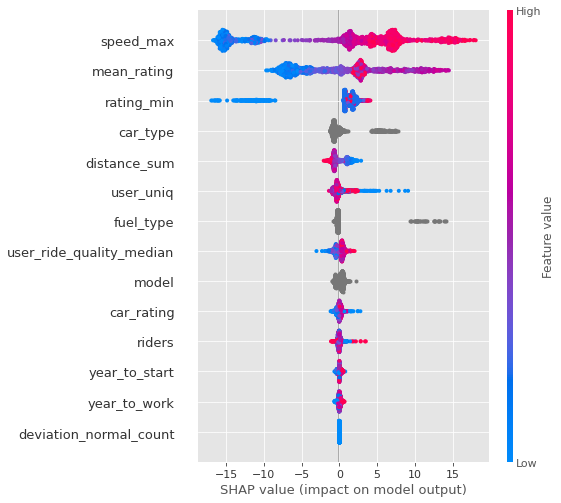

In [ ]:
explainer = shap.TreeExplainer(clfs_rs1[min_index_cb_rs])
train_dataset = Pool(data=X_train_fold[min_index_cb_rs], label=y_train_fold[min_index_cb_rs], cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
shap.summary_plot(shap_values, X_train_fold[min_index_cb_rs], max_display=25)

In [ ]:
print('object_importance',len(idxs_clfs_rs1[min_index_cb_rs]))
display(idxs_scores_clfs_rs1[min_index_cb_rs][:5])

object_importance 777


[0.24832259536540668,
 0.1703001020957874,
 0.1632268785864478,
 0.143697651274586,
 0.12137141484537411]

In [ ]:
colsdrop_cb_rs = ['deviation_normal_count']
idxs_colsdrop_cb_rs = idxs_clfs_rs1[min_index_cb_rs][:0]

train_dataset = Pool(data=X_train_fold[min_index_cb_rs].drop(index=idxs_colsdrop_cb_rs,
                                                             errors="ignore").drop(colsdrop_cb_rs, axis=1),
                     label=y_train_fold[min_index_cb_rs].drop(index=idxs_colsdrop_cb_rs,
                                                                  errors="ignore"),cat_features=cat_features)
eval_dataset = Pool(data=X_test_fold[min_index_cb_rs].drop(colsdrop_cb_rs, axis=1),
                    label=y_test_fold[min_index_cb_rs],cat_features=cat_features)

clfs_rs1f = clfs_rs1[min_index_cb_rs]
clfs_rs1f.fit(train_dataset,
              eval_set=eval_dataset,
              verbose=1000,
              use_best_model=True,
              plot=False)

score_clfs_rs1f = clfs_rs1f.best_score_['validation'].get('RMSE')
print(f"\n Model clfs_rs1f RMSE score ---------> {score_clfs_rs1f:.5f}")

0:	learn: 17.4803822	test: 16.9221843	best: 16.9221843 (0)	total: 23.4ms	remaining: 1m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.20793847
bestIteration = 183

Shrink model to first 184 iterations.

 Model clfs_rs1f RMSE score ---------> 11.20794


### CatBoostRegressor  random_state_2

In [ ]:
clfs_rs2 = []
scores_clfs_rs2 = []
idxs_clfs_rs2 = []
idxs_scores_clfs_rs2 = []

for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostRegressor(depth=6,
                            iterations=3000,
                            learning_rate=0.05,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            cat_features=cat_features,
                            l2_leaf_reg=5,
                            bootstrap_type='No',
                            thread_count=-1,
                            random_seed=random_state_2,
                            early_stopping_rounds=50)


    clfs_rs2.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=1000,
        use_best_model=True,
        plot=False)

    scores_clfs_rs2.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "RMSE" in k], dtype="float16"))

    idxs, scores = clf.get_object_importance(eval_dataset, train_dataset,
                                             importance_values_sign="Positive", thread_count=-1)
    idxs_clfs_rs2.append(idxs), idxs_scores_clfs_rs2.append(scores)

min_rmse_cb_rs2 = min(scores_clfs_rs2)
min_index_cb_rs2 = scores_clfs_rs2.index(min_rmse_cb_rs2)

assert len(clfs_rs2) == n_splits
for i in range(len(scores_clfs_rs2)):
    print(f"Model clfs_rs2 {i} RMSE score ---------> {scores_clfs_rs2[i]:.5f}")

0:	learn: 17.4719657	test: 16.8793104	best: 16.8793104 (0)	total: 20.5ms	remaining: 1m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.48342445
bestIteration = 167

Shrink model to first 168 iterations.
0:	learn: 16.8718024	test: 18.0863780	best: 18.0863780 (0)	total: 22.1ms	remaining: 1m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.06430858
bestIteration = 227

Shrink model to first 228 iterations.
0:	learn: 17.4425904	test: 16.8932297	best: 16.8932297 (0)	total: 23.4ms	remaining: 1m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.20504837
bestIteration = 193

Shrink model to first 194 iterations.
Model clfs_rs2 0 RMSE score ---------> 11.48438
Model clfs_rs2 1 RMSE score ---------> 12.06250
Model clfs_rs2 2 RMSE score ---------> 11.20312


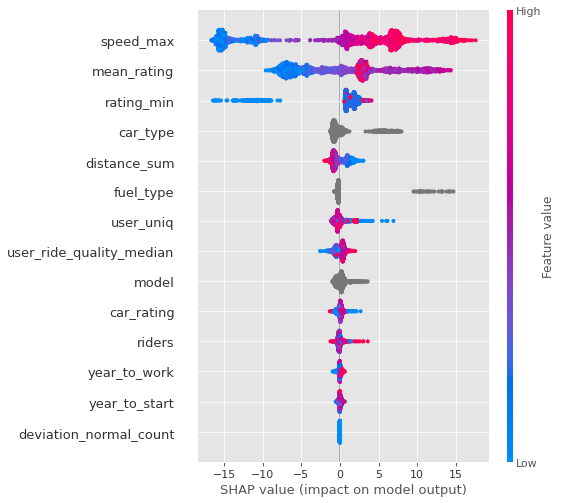

In [ ]:
explainer = shap.TreeExplainer(clfs_rs2[min_index_cb_rs2])
train_dataset = Pool(data=X_train_fold[min_index_cb_rs2], label=y_train_fold[min_index_cb_rs2], cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
shap.summary_plot(shap_values, X_train_fold[min_index_cb_rs2], max_display=25)

In [ ]:
print('object_importance',len(idxs_clfs_rs2[min_index_cb_rs2]))
display(idxs_scores_clfs_rs2[min_index_cb_rs2][:5])

object_importance 775


[0.333957827484491,
 0.20619142399716145,
 0.1670353849957942,
 0.16489806157232811,
 0.13566381163482397]

In [ ]:
colsdrop_cb_rs2 = ['deviation_normal_count']
idxs_colsdrop_cb_rs2 = idxs_clfs_rs2[min_index_cb_rs2][:5]

train_dataset = Pool(data=X_train_fold[min_index_cb_rs2].drop(idxs_colsdrop_cb_rs2,
                                                              errors="ignore").drop(colsdrop_cb_rs2, axis=1),
                     label=y_train_fold[min_index_cb_rs2].drop(idxs_colsdrop_cb_rs2,
                                                                   errors="ignore"),cat_features=cat_features)
eval_dataset = Pool(data=X_test_fold[min_index_cb_rs2].drop(colsdrop_cb_rs2, axis=1),
                    label=y_test_fold[min_index_cb_rs2],cat_features=cat_features)

clfs_rs2f = clfs_rs2[min_index_cb_rs2]
clfs_rs2f.fit(train_dataset,
              eval_set=eval_dataset,
              verbose=1000,
              use_best_model=True,
              plot=False)
score_clfs_rs2f = clfs_rs2f.best_score_['validation'].get('RMSE')
print(f"\n Model clfs_rs2f RMSE score ---------> {score_clfs_rs2f:.5f}")

0:	learn: 17.4270503	test: 16.8554272	best: 16.8554272 (0)	total: 26.7ms	remaining: 1m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.15765153
bestIteration = 203

Shrink model to first 204 iterations.

 Model clfs_rs2f RMSE score ---------> 11.15765


In [ ]:
# clfs_rs1f.save_model('../models/catboost_rs1f.cbm')
# clfs_rs2f.save_model('../models/catboost_rs2f.cbm')

<!-- Вы побили порог в 12 RMSE: ваше решение дает RMSE=11.9. Если у вас еще остались попытки, попробуйте улучшить результат! -->

## LGBMRegressor

### LGBMRegressor goss

In [ ]:
X = train.drop(drop_cols, axis=1, errors="ignore")
y = train["target_reg"]

le = LabelEncoder()
for col in cat_features:
    X[col] = le.fit_transform(X[col])

model = lgb.LGBMRegressor(random_state=random_state,
                          objective="rmse",
                          metric = "rmse",
                          boosting_type="goss",
                          n_jobs=-1,
                         )
param_grid = {'learning_rate': [0.25, 0.05],
              'reg_lambda': [0, 0.5, 1],
              'num_leaves': [5, 10],
              'max_bin': [50, 100],
              'boosting_type': ['goss']
             }

gridsearch(X, y, model, param_grid, rmse_score)


 Поиск лучших параметров...
Время подбора 0.13 минут
Лучшие параметры:    {'boosting_type': 'goss', 'learning_rate': 0.05, 'max_bin': 50, 'num_leaves': 10, 'reg_lambda': 0.5}
Лучшая оценка rmse:  11.95

 Поиск лучших параметров...
Время подбора 0.03 минут
Лучшие параметры:    {'boosting_type': 'goss', 'learning_rate': 0.05, 'max_bin': 50, 'num_leaves': 10, 'reg_lambda': 0.5}
Лучшая оценка rmse:  11.67

 Поиск лучших параметров...
Время подбора 0.03 минут
Лучшие параметры:    {'boosting_type': 'goss', 'learning_rate': 0.05, 'max_bin': 100, 'num_leaves': 10, 'reg_lambda': 0}
Лучшая оценка rmse:  12.04


In [ ]:
lgb_goss = []
scores_lgb_goss = []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_model = lgb.LGBMRegressor(objective="rmse",
                                  learning_rate=0.05,
                                  random_state=random_state,
                                  cat_feature=[0, 1, 2],
                                  boosting_type="goss",
                                  max_bin=50,
                                  num_leaves=10,
                                  reg_lambda=0.5,
                                  n_jobs=-1,
                                 )
    lgb_model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
                  early_stopping_rounds=50,
                  verbose=1000,)
    lgb_goss.append(lgb_model)
    scores_lgb_goss.append(np.mean([v for k, v in lgb_model.best_score_["valid_0"].items()
                                    if "rmse" in k], dtype="float16"))
min_rmse_lgb_goss = min(scores_lgb_goss)
min_index_lgb_goss = scores_lgb_goss.index(min_rmse_lgb_goss)
assert len(lgb_goss) == n_splits
for i in range(len(scores_lgb_goss)):
    print(f"Model lgb_models_goss {i} RMSE score ---------> {scores_lgb_goss[i]:.5f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 11.6763
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 12.5464
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's rmse: 11.4297
Model lgb_models_goss 0 RMSE score ---------> 11.67969
Model lgb_models_goss 1 RMSE score ---------> 12.54688
Model lgb_models_goss 2 RMSE score ---------> 11.42969


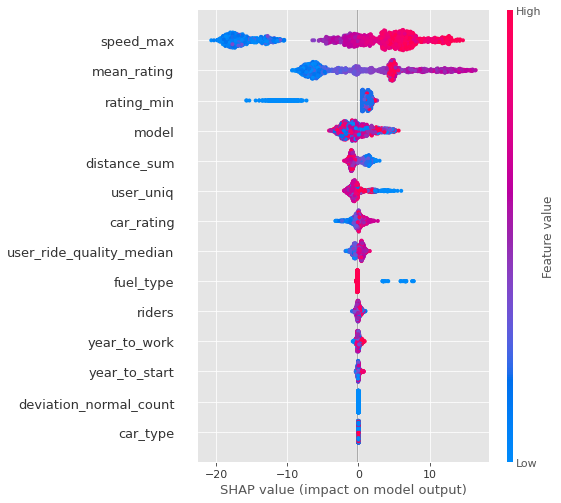

In [ ]:
X_train_fold_le_goss = X_train_fold[min_index_lgb_goss].copy()
X_test_fold_le_goss = X_test_fold[min_index_lgb_goss].copy()

for col in cat_features:
    X_train_fold_le_goss[col] = le.fit_transform(X_train_fold_le_goss[col])
    X_test_fold_le_goss[col] = le.fit_transform(X_test_fold_le_goss[col])

explainer = shap.TreeExplainer(lgb_goss[min_index_lgb_goss])
shap_values = explainer.shap_values(X_train_fold_le_goss)
shap.summary_plot(shap_values, X_train_fold_le_goss, max_display=25)

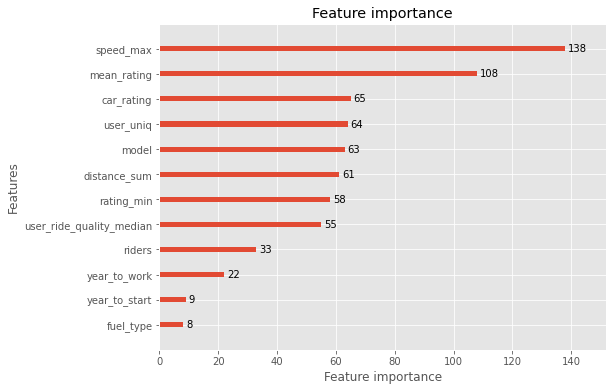

In [ ]:
lgb.plot_importance(lgb_goss[min_index_lgb_goss], figsize=(8, 6));

In [ ]:
colsdrop_lgb_gossf = ['deviation_normal_count','car_type', 'year_to_start', 'year_to_work']

lgb_gossf = lgb.LGBMRegressor(objective="rmse",
                              learning_rate=0.05,
                              random_state=random_state,
                              cat_feature=[0,1],
                              boosting_type="goss",
                              max_bin=50,
                              num_leaves=10,
                              reg_lambda=0.5,
                              n_jobs=-1,
                             )
lgb_gossf.fit(X_train_fold_le_goss.drop(colsdrop_lgb_gossf, axis=1),
              y_train_fold[min_index_lgb_goss],
              eval_set=[(X_test_fold_le_goss.drop(colsdrop_lgb_gossf, axis=1),
                         y_test_fold[min_index_lgb_goss])],
              eval_metric='rmse',
              early_stopping_rounds=50,
              verbose=1000,)

score_lgb_gossf = lgb_gossf.best_score_['valid_0'].get('rmse')
print(f"\n Model lgb_gossf RMSE score ---------> {score_lgb_gossf:.5f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's rmse: 11.3825

 Model lgb_gossf RMSE score ---------> 11.38255


### LGBMRegressor dart

In [ ]:
X = train.drop(drop_cols, axis=1, errors="ignore")
y = train["target_reg"]

le = LabelEncoder()
for col in cat_features:
    X[col] = le.fit_transform(X[col])

param_grid = {'learning_rate': [0.25, 0.05],
              'reg_lambda': [0, 0.5, 1],
              'num_leaves': [5, 10],
              'max_bin': [50, 200, 400],
              'boosting_type': ['dart']
             }

model = lgb.LGBMRegressor(random_state=random_state,
                          objective="rmse",
                          metric = "rmse"
                          )

gridsearch(X, y, model, param_grid, rmse_score)


 Поиск лучших параметров...
Время подбора 0.06 минут
Лучшие параметры:    {'boosting_type': 'dart', 'learning_rate': 0.25, 'max_bin': 50, 'num_leaves': 5, 'reg_lambda': 1}
Лучшая оценка rmse:  11.6

 Поиск лучших параметров...
Время подбора 0.06 минут
Лучшие параметры:    {'boosting_type': 'dart', 'learning_rate': 0.25, 'max_bin': 400, 'num_leaves': 10, 'reg_lambda': 1}
Лучшая оценка rmse:  11.33

 Поиск лучших параметров...
Время подбора 0.06 минут
Лучшие параметры:    {'boosting_type': 'dart', 'learning_rate': 0.25, 'max_bin': 50, 'num_leaves': 5, 'reg_lambda': 0}
Лучшая оценка rmse:  11.65


In [ ]:
lgb_dart = []
scores_lgb_dart = []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_model = lgb.LGBMRegressor(objective="rmse",
                                  learning_rate=0.25,
                                  random_state=random_state,
                                  cat_feature=[0, 1, 2],
                                  boosting_type="dart",
                                  max_bin=400,
                                  num_leaves=10,
                                  reg_lambda=1,
                                  n_jobs=-1,
                                 )
    lgb_model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test),],
                  eval_metric='rmse',
                  early_stopping_rounds=50,
                  verbose=1000,)
    lgb_dart.append(lgb_model)
    scores_lgb_dart.append(np.mean([v for k, v in lgb_model.best_score_["valid_0"].items()
                                    if "rmse" in k], dtype="float16"))
min_rmse_lgb_dart = min(scores_lgb_dart)
min_index_lgb_dart = scores_lgb_dart.index(min_rmse_lgb_dart)
assert len(lgb_dart) == n_splits
for i in range(len(scores_lgb_dart)):
    print(f"Model lgb_models_dart {i} RMSE score ---------> {scores_lgb_dart[i]:.5f}")

Model lgb_models_dart 0 RMSE score ---------> 11.78906
Model lgb_models_dart 1 RMSE score ---------> 12.25000
Model lgb_models_dart 2 RMSE score ---------> 11.42188


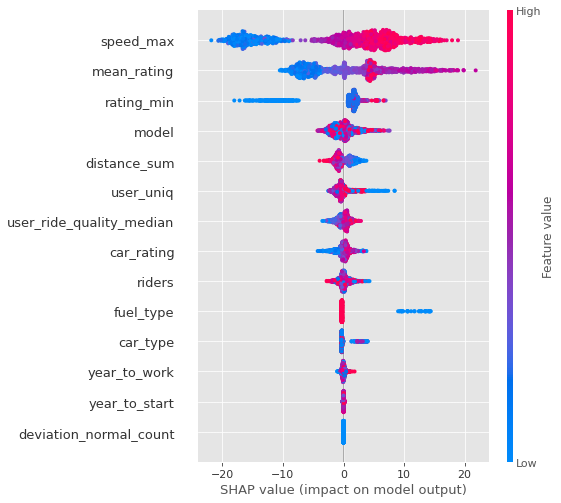

In [ ]:
X_train_fold_le_dart = X_train_fold[min_index_lgb_dart].copy()
X_test_fold_le_dart = X_test_fold[min_index_lgb_dart].copy()
for col in cat_features:
    X_train_fold_le_dart[col] = le.fit_transform(X_train_fold_le_dart[col])
    X_test_fold_le_dart[col] = le.fit_transform(X_test_fold_le_dart[col])

explainer = shap.TreeExplainer(lgb_dart[min_index_lgb_dart])
shap_values = explainer.shap_values(X_train_fold_le_dart)
shap.summary_plot(shap_values, X_train_fold_le_dart, max_display=25)

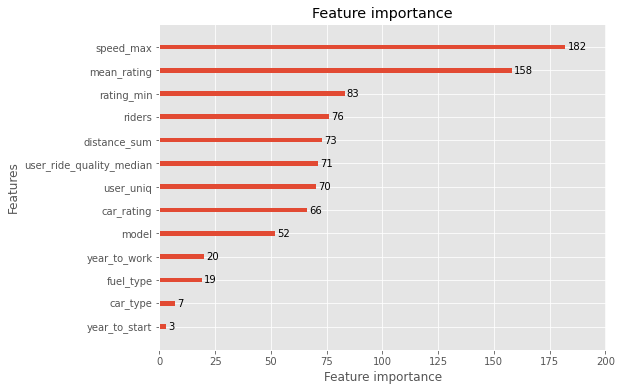

In [ ]:
lgb.plot_importance(lgb_dart[min_index_lgb_dart], figsize=(8, 6));

In [ ]:
colsdrop_lgb_dartf = ['deviation_normal_count', 'year_to_start', 'year_to_work']

lgb_dartf = lgb.LGBMRegressor(objective="rmse",
                              learning_rate=0.25,
                              random_state=random_state,
                              cat_feature=[0,1,2],
                              boosting_type="dart",
                              max_bin=400,
                              num_leaves=10,
                              reg_lambda=1,
                              n_jobs=-1,
                             )
lgb_dartf.fit(X_train_fold_le_dart.drop(colsdrop_lgb_dartf, axis=1),
              y_train_fold[min_index_lgb_dart],
              eval_set=[(X_test_fold_le_dart.drop(colsdrop_lgb_dartf, axis=1),
                         y_test_fold[min_index_lgb_dart])],
              eval_metric='rmse',
              early_stopping_rounds=50,
              verbose=1000,)

score_lgb_dartf = lgb_dartf.best_score_['valid_0'].get('rmse')
print(f"\n Model lgb_dartf RMSE score ---------> {lgb_dartf.best_score_['valid_0'].get('rmse'):.5f}")


 Model lgb_dartf RMSE score ---------> 11.35939


In [ ]:
# booster_lgb_gossf, booster_lgb_dartf  = lgb_gossf.booster_, lgb_dartf.booster_
# booster_lgb_gossf.save_model('../models/lgb_gossf.cbm')
# booster_lgb_dartf.save_model('../models/lgb_dartf.cbm')

## XGBRegressor

### XGBRegressor dart

In [ ]:
X = train.drop(drop_cols, axis=1, errors="ignore")
y = train["target_reg"]
for col in cat_features:
    X[col] = X[col].astype('category')

model = xgb.XGBRegressor(random_state=random_state,
                         objective= 'reg:squarederror',
                         tree_method="hist",
                         enable_categorical=True,
                         n_jobs=-1,
                         )

param_grid = {'max_depth': [3, 5],
              'max_leaves': [7, 9],
              'min_child_weight': [12, 14],
              'rate_drop': [0.05, 0.1],
              'one_drop': [1],
              'booster':['dart']
              }

gridsearch(X, y, model, param_grid, rmse_score)


 Поиск лучших параметров...
Время подбора 2.53 минут
Лучшие параметры:    {'booster': 'dart', 'max_depth': 3, 'max_leaves': 9, 'min_child_weight': 14, 'one_drop': 1, 'rate_drop': 0.1}
Лучшая оценка rmse:  11.73

 Поиск лучших параметров...
Время подбора 2.61 минут
Лучшие параметры:    {'booster': 'dart', 'max_depth': 5, 'max_leaves': 9, 'min_child_weight': 14, 'one_drop': 1, 'rate_drop': 0.1}
Лучшая оценка rmse:  11.55

 Поиск лучших параметров...
Время подбора 2.49 минут
Лучшие параметры:    {'booster': 'dart', 'max_depth': 3, 'max_leaves': 9, 'min_child_weight': 14, 'one_drop': 1, 'rate_drop': 0.05}
Лучшая оценка rmse:  11.68


In [ ]:
xgb_dart = []
scores_xgb_dart = []
num_boost_round_ = 1000

learning_rates = np.linspace(0.5, 0.001, num_boost_round_).tolist()
scheduler = xgb.callback.LearningRateScheduler(learning_rates)

params_dart = {'objective': 'reg:squarederror',
               'tree_method': 'hist',
               'seed': random_state,
               'booster': 'dart',
               'max_depth': '5',
               'max_leaves': '9',
               'min_child_weight': '14',
               'one_drop': '1',
               'rate_drop': '0.1',
               'n_jobs': '-1',
              }
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, nthread=-1, enable_categorical=True)

    booster = xgb.train(params_dart,
                        dtrain=dtrain,
                        num_boost_round=num_boost_round_,
                        evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                        verbose_eval=1000,
                        callbacks=[scheduler],
                        early_stopping_rounds=100,
                       )

    xgb_dart.append(booster)
    scores_xgb_dart.append(np.mean(booster.best_score))
min_rmse_xgb_dart = min(scores_xgb_dart)
min_index_xgb_dart = scores_xgb_dart.index(min_rmse_xgb_dart)
assert len(xgb_dart) == n_splits
for i in range(len(scores_xgb_dart)):
    print(f"Model xgb_dart {i} RMSE score ---------> {scores_xgb_dart[i]:.5f}")

[0]	dtrain-rmse:34.63970	dtest-rmse:34.78987
[235]	dtrain-rmse:10.17747	dtest-rmse:11.50565
[0]	dtrain-rmse:34.42810	dtest-rmse:35.61910
[156]	dtrain-rmse:10.04160	dtest-rmse:11.92093
[0]	dtrain-rmse:34.96338	dtest-rmse:33.84788
[330]	dtrain-rmse:10.19529	dtest-rmse:11.36011
Model xgb_dart 0 RMSE score ---------> 11.48149
Model xgb_dart 1 RMSE score ---------> 11.86981
Model xgb_dart 2 RMSE score ---------> 11.35429


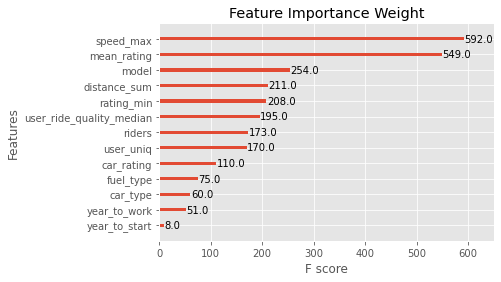

In [ ]:
xgb.plot_importance(xgb_dart[min_index_xgb_dart], title='Feature Importance Weight');

In [ ]:
colsdrop_xgb_dartf = ['deviation_normal_count', 'year_to_start', 'year_to_work', 'car_type', 'fuel_type']

dtrain = xgb.DMatrix(X_train_fold[min_index_xgb_dart].drop(colsdrop_xgb_dartf, axis=1),
                     label=y_train_fold[min_index_xgb_dart],
                     nthread=-1, enable_categorical=True)
dtest = xgb.DMatrix(X_test_fold[min_index_xgb_dart].drop(colsdrop_xgb_dartf, axis=1),
                    y_test_fold[min_index_xgb_dart],
                    nthread=-1, enable_categorical=True)

boosterf = xgb.train(params_dart,
                     dtrain=dtrain,
                     num_boost_round=num_boost_round_,
                     evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                     verbose_eval=1000,
                     callbacks=[scheduler],
                     early_stopping_rounds=100,
                     )
xgb_dartf = boosterf
score_xgb_dartf = xgb_dartf.best_score
print(f"\n Model xgb_dartf RMSE score ---------> {score_xgb_dartf:.5f}")

[0]	dtrain-rmse:34.98074	dtest-rmse:33.80421
[257]	dtrain-rmse:10.22438	dtest-rmse:11.34067

 Model xgb_dartf RMSE score ---------> 11.33184


### XGBRegressor gbtree

In [ ]:
X = train.drop(drop_cols, axis=1, errors="ignore")
y = train["target_reg"]
for col in cat_features:
    X[col] = X[col].astype('category')

model = xgb.XGBRegressor(random_state=random_state,
                         objective= 'reg:squarederror',
                         tree_method="hist",
                         enable_categorical=True,
                         n_jobs=-1,
                          )

param_grid = {'max_depth': [2, 3],
              'max_leaves': [2, 5, 7],
              'colsample_bytree': [0.6, 0.8],
              'min_child_weight': [14, 16],
              'booster': ['gbtree'],
             }

gridsearch(X, y, model, param_grid, rmse_score)


 Поиск лучших параметров...
Время подбора 0.05 минут
Лучшие параметры:    {'booster': 'gbtree', 'colsample_bytree': 0.8, 'max_depth': 2, 'max_leaves': 5, 'min_child_weight': 16}
Лучшая оценка rmse:  11.97

 Поиск лучших параметров...
Время подбора 0.05 минут
Лучшие параметры:    {'booster': 'gbtree', 'colsample_bytree': 0.6, 'max_depth': 2, 'max_leaves': 5, 'min_child_weight': 16}
Лучшая оценка rmse:  11.79

 Поиск лучших параметров...
Время подбора 0.05 минут
Лучшие параметры:    {'booster': 'gbtree', 'colsample_bytree': 0.8, 'max_depth': 2, 'max_leaves': 5, 'min_child_weight': 16}
Лучшая оценка rmse:  12.02


In [ ]:
xgb_gbtree = []
scores_xgb_gbtree = []

learning_rates = np.linspace(0.5, 0.0001, num_boost_round_).tolist()
scheduler = xgb.callback.LearningRateScheduler(learning_rates)

params_gbtree = {'objective': 'reg:squarederror',
                 'tree_method': 'hist',
                 'seed': random_state,
                 'booster': 'gbtree',
                 'colsample_bytree': '0.6',
                 'max_depth': '2',
                 'min_child_weight': '16',
                 'max_leaves': '5',
                 'n_jobs': '-1',
                 }

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, nthread=-1, enable_categorical=True)

    booster = xgb.train(params_gbtree,
                        dtrain=dtrain,
                        num_boost_round=num_boost_round_,
                        evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                        verbose_eval=1000,
                        callbacks=[scheduler],
                        early_stopping_rounds=100
                      )
    xgb_gbtree.append(booster)
    scores_xgb_gbtree.append(np.mean(booster.best_score))
min_rmse_xgb_gbtree = min(scores_xgb_gbtree)
min_index_xgb_gbtree = scores_xgb_gbtree.index(min_rmse_xgb_gbtree)
assert len(xgb_gbtree) == n_splits
for i in range(len(scores_xgb_gbtree)):
    print(f"Model xgb_gbtree {i} RMSE score ---------> {scores_xgb_gbtree[i]:.5f}")

[0]	dtrain-rmse:35.55946	dtest-rmse:35.82073
[113]	dtrain-rmse:9.23294	dtest-rmse:12.21347
[0]	dtrain-rmse:35.30585	dtest-rmse:36.32021
[133]	dtrain-rmse:8.77268	dtest-rmse:12.54187
[0]	dtrain-rmse:35.91484	dtest-rmse:34.62261
[122]	dtrain-rmse:9.09923	dtest-rmse:12.18670
Model xgb_gbtree 0 RMSE score ---------> 11.92471
Model xgb_gbtree 1 RMSE score ---------> 12.20955
Model xgb_gbtree 2 RMSE score ---------> 11.84714


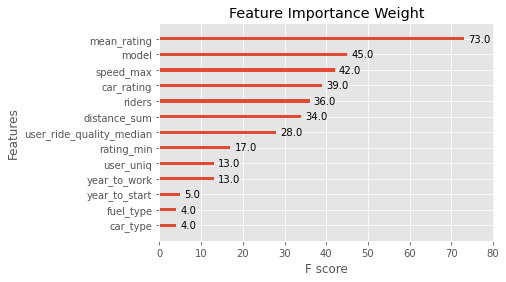

In [ ]:
xgb.plot_importance(xgb_gbtree[min_index_xgb_gbtree], title='Feature Importance Weight');

In [ ]:
colsdrop_xgb_gbtreef = ['deviation_normal_count', 'year_to_start', 'year_to_work', 'car_type', 'fuel_type']

dtrain = xgb.DMatrix(X_train_fold[min_index_xgb_gbtree].drop(colsdrop_xgb_gbtreef, axis=1),
                     label=y_train_fold[min_index_xgb_gbtree],
                     nthread=-1, enable_categorical=True)
dtest = xgb.DMatrix(X_test_fold[min_index_xgb_gbtree].drop(colsdrop_xgb_gbtreef, axis=1),
                    y_test_fold[min_index_xgb_gbtree],
                    nthread=-1, enable_categorical=True)

boosterf = xgb.train(params_gbtree,
                     dtrain=dtrain,
                     num_boost_round=num_boost_round_,
                     evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                     verbose_eval=1000,
                     callbacks=[scheduler],
                     early_stopping_rounds=100,
                     )
xgb_gbtreef = boosterf
score_xgb_gbtreef = xgb_gbtreef.best_score
print(f"\n Model xgb_dartf RMSE score ---------> {score_xgb_gbtreef:.5f}")

[0]	dtrain-rmse:35.31663	dtest-rmse:34.12192
[127]	dtrain-rmse:9.07323	dtest-rmse:12.17889

 Model xgb_dartf RMSE score ---------> 11.72837


In [ ]:
# xgb_dartf.save_model('../models/xgb_dartf.json')
# xgb_gbtreef.save_model('../models/xgb_gbtreef.json')

## Лучшие модели


In [ ]:
print(f'Лучшие модели:\n')

print(f'clfs_rs1    MIN index {min_index_cb_rs} --- {min_rmse_cb_rs:.5f}')
print(f'clfs_rs1f   MIN index {0} --- {score_clfs_rs1f:.5f}')
print(f'clfs_rs2    MIN index {min_index_cb_rs2} --- {min_rmse_cb_rs2:.5f}')
print(f'clfs_rs2f   MIN index {0} --- {score_clfs_rs2f:.5f}\n')

print(f'lgb_goss    MIN index {min_index_lgb_goss} --- {min_rmse_lgb_goss:.5f}')
print(f'lgb_gossf   MIN index {0} --- {score_lgb_gossf:.5f}')
print(f'lgb_dart    MIN index {min_index_lgb_dart} --- {min_rmse_lgb_dart:.5f}')
print(f'lgb_dartf   MIN index {0} --- {score_lgb_dartf:.5f}\n')

print(f'xgb_dart    MIN index {min_index_xgb_dart} --- {min_rmse_xgb_dart:.5f}')
print(f'xgb_dartf   MIN index {0} --- {score_xgb_dartf:.5f}')
print(f'xgb_gbtree  MIN index {min_index_xgb_gbtree} --- {min_rmse_xgb_gbtree:.5f}')
print(f'xgb_gbtreef MIN index {0} --- {score_xgb_gbtreef:.5f}\n')


Лучшие модели:

clfs_rs1    MIN index 2 --- 11.21094
clfs_rs1f   MIN index 0 --- 11.20794
clfs_rs2    MIN index 2 --- 11.20312
clfs_rs2f   MIN index 0 --- 11.15765

lgb_goss    MIN index 2 --- 11.42969
lgb_gossf   MIN index 0 --- 11.38255
lgb_dart    MIN index 2 --- 11.42188
lgb_dartf   MIN index 0 --- 11.35939

xgb_dart    MIN index 2 --- 11.35429
xgb_dartf   MIN index 0 --- 11.33184
xgb_gbtree  MIN index 2 --- 11.84714
xgb_gbtreef MIN index 0 --- 11.72837



In [ ]:
end_time = time.time() - start_time
print(f'Время отработки ноутбука {round((end_time)/60, 2)} минут')

Время отработки ноутбука 16.74 минут


Итого получили лучшие модели обученные на 3 фолдах:
- **CatBoostRegressor**  с `random_state` = 830425 и = 12345 лучший на 3 фолде (индекс 2)
- **LGBMRegressor** c `boosting_type` goss и dart лучший на 3 фолде
- **XGBRegressor** c `boosting_type` dart и gbtree также лучший на 3 фолде

Самый высокий score на обучающих данных оказался у CatBoostRegressor, далее LGBMRegressor, наименьший score у XGBRegressor.
А вот быстрее всего обучается модель LGBMRegressor.

Для лучших моделей из train датасета удалили несколько маловажных признаков - таким образом удалось немного повысить score. Получили модели с буквой `f` в конце имени - их и будем использовать для предсказания.

Далее сделаем predict 6 лучших моделей, усредним и сохраним в файл.

In [ ]:
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv")
test_drop = test.drop(["car_id",'target_class'], axis=1)

test_lgbm = test_drop.copy()
for col in cat_features:
    test_lgbm[col] = le.fit_transform(test_lgbm[col])

test_xgb = test_drop.copy()
for col in cat_features:
    test_xgb[col] = test_xgb[col].astype('category')

test_xgb_dartf = xgb.DMatrix(test_xgb.drop(colsdrop_xgb_dartf, axis=1),
                             nthread=-1,
                             enable_categorical=True)
test_xgb_gbtreef = xgb.DMatrix(test_xgb.drop(colsdrop_xgb_gbtreef, axis=1),
                              nthread=-1,
                              enable_categorical=True)

In [ ]:
test['target_reg_cb_1'] = clfs_rs1f.predict(test_drop.drop(colsdrop_cb_rs, axis=1))
test['target_reg_cb_2'] = clfs_rs2f.predict(test_drop.drop(colsdrop_cb_rs2, axis=1))
test['target_reg_lgbm_1'] = lgb_gossf.predict(test_lgbm.drop(colsdrop_lgb_gossf, axis=1))
test['target_reg_lgbm_2'] = lgb_dartf.predict(test_lgbm.drop(colsdrop_lgb_dartf, axis=1))
test['target_reg_xgb_1'] = xgb_dartf.predict(test_xgb_dartf, iteration_range=(0, xgb_dartf.best_iteration+1))
test['target_reg_xgb_2'] = xgb_gbtreef.predict(test_xgb_gbtreef)

test['target_reg_mean'] = test[['target_reg_cb_1','target_reg_cb_2',
                                'target_reg_lgbm_1','target_reg_lgbm_2',
                                'target_reg_xgb_1','target_reg_xgb_2'
                               ]].mean(axis=1)

In [ ]:
test['target_reg'] = test['target_reg_mean']
# test[['car_id', 'target_reg']].to_csv('../subs/simple_baseline_target_reg_RMSE_less12.csv', index=False)
# print('CSV file saved!')

CSV file saved!
